In [2]:
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from independent_set_solver import solve_max_independent_set_integer
from scipy.sparse import lil_matrix
from tqdm import tqdm
from pydrake.all import Hyperellipsoid

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
eps_sample = -0.05
world_name = "cheese102.instance.json"#small_polys[1] #"cheese205.instance.json"#fpg-poly_0000000060_h1.instance.json"#"srpg_iso_aligned_mc0000172.instance.json"##"fpg-poly_0000000070_h1.instance.json"
world = World("./data/evalexamples/"+world_name)
world.build_offset_cfree(eps_sample)

def sample_cfree_handle(n, m, regions=None):
	points = np.zeros((n,2))
	if regions is None: regions = []		
	for i in range(n):
		bt_tries = 0
		while bt_tries<m:
			point = world.sample_cfree_distance(1, eps = eps_sample)[0]
			#point = world.sample_cfree(1)[0]
			if point_near_regions(point, regions, tries = 100, eps = 0.1):
				bt_tries+=1
			else:
				break
		if bt_tries == m:
			return points, True
		
		points[i] = point
	return points, False

def vgraph_builder(points, regions, region_vis_obstacles=True):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			if region_vis_obstacles:
				if vis_reg(point, other, world, regions):
					adj_mat[i,j] = adj_mat[j,i] = 1
			else:
				if vis_reg(point, other, world, []):
					adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()




In [68]:
import numpy as np
from pydrake.all import (MathematicalProgram, SolverOptions, 
			            Solve, CommonSolverOption)

from ellipse_utils import get_lj_ellipse
import networkx as nx
def collision(pt):
    return world.visible(pt,pt)

def compute_minimum_clique_partition(adj_mat):
    prog = MathematicalProgram()
    n = adj_mat.shape[0]
    adj_compl = 1- adj_mat
    np.fill_diagonal(adj_compl, 0)
    max_num_colors = 44 #n/10
    #color variables
    x = prog.NewBinaryVariables(n,max_num_colors)
    #indexvariables for the color
    w = prog.NewBinaryVariables(max_num_colors)
    #one color per vertex
    for i in range(n):
        prog.AddLinearConstraint(np.sum(x[i, :])==1)

    for c in range(max_num_colors):
        for i in range(0,n):
                for j in range(i,n):
                    if adj_compl[i,j]:
                        prog.AddLinearConstraint(x[i, c] + x[j, c] <= w[c])

    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)
    prog.AddLinearCost(np.sum(w))
    result = Solve(prog, solver_options=solver_options)
    clique_colors = np.where(result.GetSolution(w) == 1)[0]
    cliques = []
    xsol = result.GetSolution(x)
    for col in clique_colors:
        cliques.append(np.where(xsol[:,col] ==1)[0])
    return result.get_optimal_cost(), cliques

def greedy_clique_partition(adj_mat):
    n = len(adj_mat)

    adj_compl = 1- adj_mat
    np.fill_diagonal(adj_compl, 0)
    graph = nx.Graph(adj_compl)
    sol = nx.greedy_color(graph, strategy='largest_first', interchange=True)

    colors= [sol[i] for i in range(n)]
    unique_colors = list(set(colors))
    cliques = []
    nr_cliques = len(unique_colors)
    for col in unique_colors:
        cliques.append(np.where(np.array(colors) == col)[0])
    return nr_cliques, cliques
    # Sort the vertices based on their degree (number of connections)
    sorted_vertices = sorted(range(n), key=lambda x: sum(adj_mat[x]), reverse=True)

    # Assign the smallest available color to each vertex
    for vertex in sorted_vertices:
        available_colors = set(range(n))
        for neighbor in range(n):
            if adj_compl[vertex, neighbor] == 1 and result[neighbor] in available_colors:
                available_colors.remove(result[neighbor])
        result[vertex] = min(available_colors)

    # Calculate the chromatic number
    nr_cliques = max(result) + 1
    result = np.array(result)
    cliques =[]
    for i in range(nr_cliques):
        cliques.append(np.where(result == i)[0])
    return nr_cliques, cliques

def get_kernel_iris_metrics(cliques):
    seed_ellipses = [get_lj_ellipse(k) for k in cliques]
    seed_points = []
    for k,se in zip(cliques, seed_ellipses):
        center = se.center()
        if not collision(center):
            distances = np.linalg.norm(np.array(k).reshape(-1,2) - center, axis = 1).reshape(-1)
            mindist_idx = np.argmin(distances)
            seed_points.append(k[mindist_idx])
        else:
            seed_points.append(center)

    #rescale seed_ellipses
    mean_eig_scaling = 1000
    seed_ellipses_scaled = []
    for e in seed_ellipses:
        eigs, _ = np.linalg.eig(e.A())
        mean_eig_size = np.mean(eigs)
        seed_ellipses_scaled.append(Hyperellipsoid(e.A()*(mean_eig_scaling/mean_eig_size), e.center()))
    #sort by size
    idxs = np.argsort([s.Volume() for s in seed_ellipses])[::-1]
    hs = [seed_points[i] for i in idxs]
    se = [seed_ellipses_scaled[i] for i in idxs]
    return hs, se

In [71]:
N = 300
pts, _ = sample_cfree_handle(N, 3000,[])
adj_mat = vgraph_builder(pts, [], True)
val, ind_set_idx_tuple  = solve_max_independent_set_integer(adj_mat=adj_mat)
ind_set_idx = ind_set_idx_tuple[0]
kernels = compute_kernels(ind_set_idx, adj_mat)
#nr_cliques, cliques = compute_minimum_clique_partition(adj_mat)
nr_cliques, cliques = greedy_clique_partition(adj_mat)
print(nr_cliques)

100%|██████████| 300/300 [00:18<00:00, 15.88it/s]


19


In [72]:
from pydrake.all import VPolytope, HPolyhedron
from scipy.spatial import ConvexHull

seed_ellipses = []
for c in cliques:
    pts_c =  pts[c, :]
    HE= get_lj_ellipse(pts_c)
    seed_ellipses.append(HE)
    
seed_polys = []
for c in cliques:
    if len(c)>= 3:
        pts_clique = pts[c,:]
        hull = ConvexHull(pts_clique)
        hull_vertices = pts_clique[hull.vertices, :]
        seed_polys.append(VPolytope(hull_vertices.T))
    else:
        seed_polys.append(None)

In [73]:
seed_points, metrics = get_kernel_iris_metrics([pts[c,:] for c in cliques])

In [74]:
import shapely
from shapely.ops import cascaded_union
from region_generation import generate_regions_ellipses_multi_threading
from seeding_utils import sorted_vertices

eps = 0.05
def compute_coverage(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def compute_coverage_cfree_tot(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def iris_w_obstacles(points, ellipsoids, region_obstacles, old_regions = None, use_region_obstacles = False):
    if N>=1:
        #+ region_obstacles
        obstacles = [r for r in world.obstacle_triangles]
        if use_region_obstacles:
            obstacles += region_obstacles
        regions, _, is_full = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain, compute_coverage, coverage_threshold=1-eps, old_regs = old_regions, maxiters=3)
    # else:
    #     #if N=1 coverage estimate happens at every step
    #     obstacles = [r for r in world.obstacle_triangles]
    #     if use_region_obstacles:
    #         obstacles += region_obstacles
    #     regions, _, _ = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain)
    #     is_full = 1-eps <= compute_coverage(old_regions+regions)
    return regions, is_full

In [75]:
regions, is_full = iris_w_obstacles(seed_points, metrics, [], [])

[19:14:26]  1 / 1
[19:14:28]  1 / 1


<ipython-input-74-5f0ff43fff2e>:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


[19:14:30]  1 / 1
[19:14:31]  1 / 1
[19:14:33]  1 / 1
[19:14:35]  1 / 1
[19:14:37]  1 / 1
[19:14:38]  1 / 1


In [ ]:
print(len(regions))
compute_coverage(regions)

25


<ipython-input-47-5f0ff43fff2e>:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


0.8986454193395809

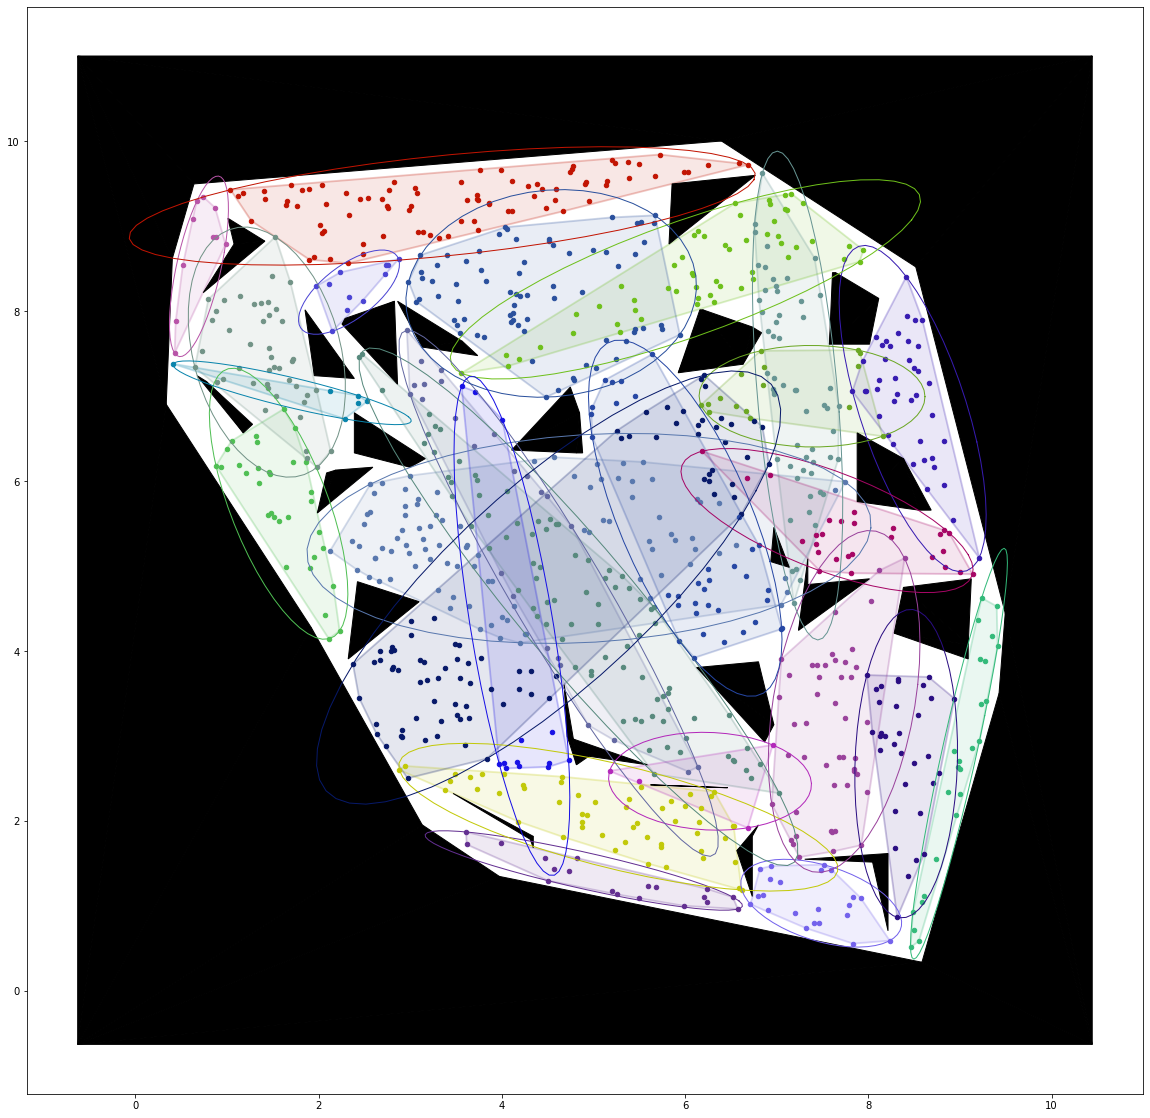

In [ ]:
from utils import generate_random_colors
from seeding_utils import sorted_vertices
from ellipse_utils import plot_ellipse
fig,ax = plt.subplots(figsize = (20,20))
ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)

colors = generate_random_colors(len(cliques))
for idx, c in enumerate(cliques):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    seed_ell = seed_ellipses[idx]
    scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = colc, zorder = 0)

        ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)
    if seed_ell is not None:plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

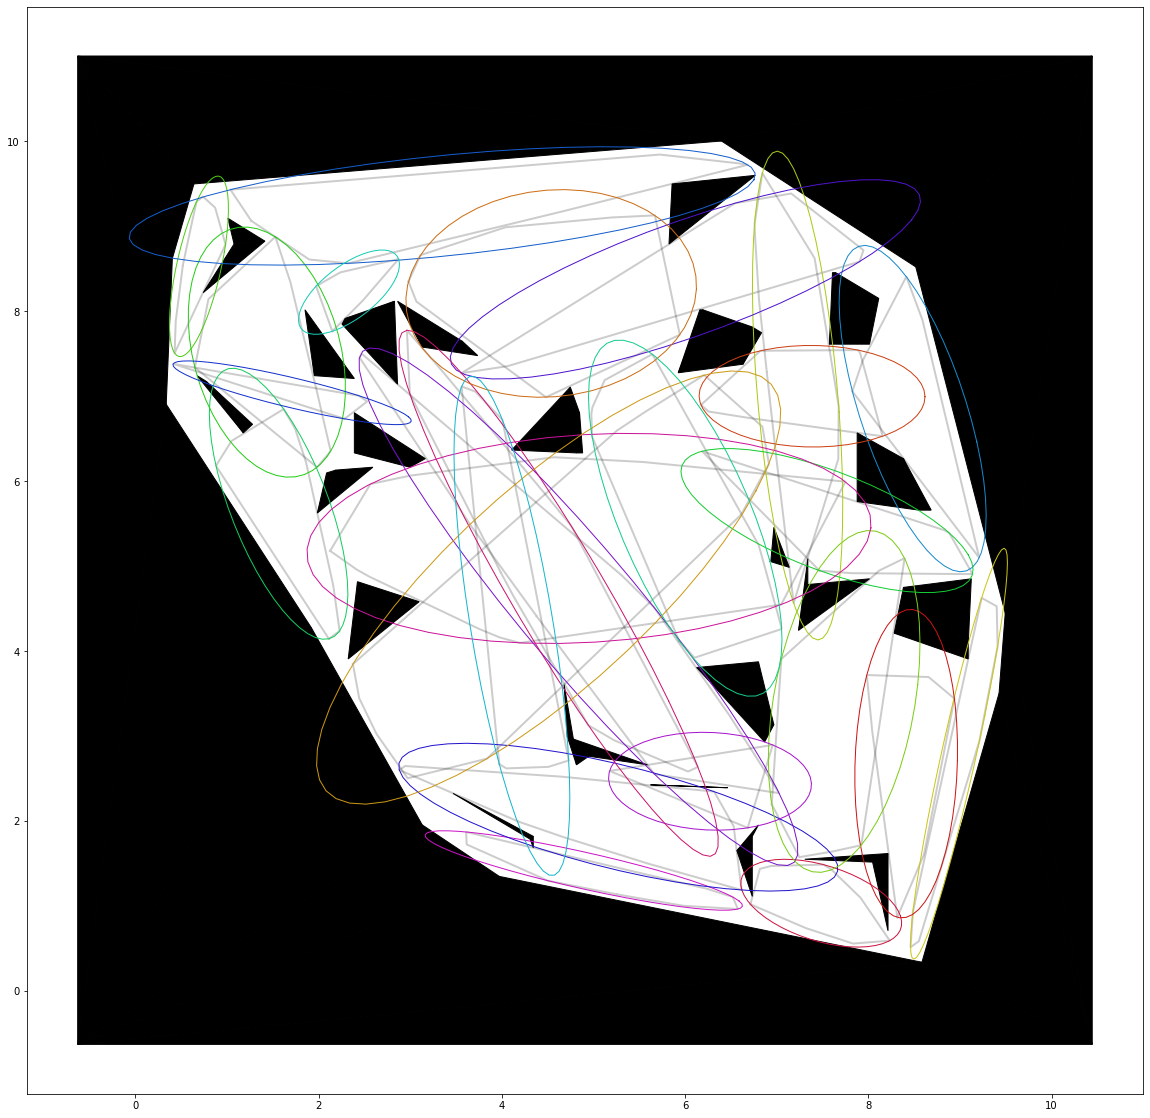

In [ ]:
from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices
from ellipse_utils import plot_ellipse
fig,ax = plt.subplots(figsize = (20,20))
# ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)

colors = generate_maximally_different_colors(len(cliques))
for idx, c in enumerate(cliques):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    seed_ell = seed_ellipses[idx]
    reg = regions[idx]
    #scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = 'k', zorder = 0)

        #ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)
    v = sorted_vertices(VPolytope(reg)).T#s
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.7, c = colc, zorder = 0)
    ax.fill(v[:,0], v[:,1], alpha = 0.3, c = p[0].get_color(), zorder = 0)
    #if seed_ell is not None: plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

In [14]:
def compute_largest_seed_cliques(adj_mat):
    cliques = []
    done = False
    adj_curr = adj_mat.copy()
    adj_curr = 1- adj_curr
    np.fill_diagonal(adj_curr, 0)
    ind_curr = np.arange(len(adj_curr))
    while not done:
        val, ind_max_clique_local = solve_max_independent_set_integer(adj_curr)
        #non_max_ind_local = np.arange(len(adj_curr))
        #non_max_ind_local = np.delete(non_max_ind_local, ind_max_clique_local, None)
        index_max_clique_global = np.array([ind_curr[i] for i in ind_max_clique_local])
        cliques.append(index_max_clique_global.reshape(-1))
        adj_curr = np.delete(adj_curr, ind_max_clique_local, 0)
        adj_curr = np.delete(adj_curr, ind_max_clique_local, 1)
        ind_curr = np.delete(ind_curr, ind_max_clique_local)
        if len(adj_curr) == 0:
            done = True
    return cliques

In [15]:
cliques_max = compute_largest_seed_cliques(adj_mat)

In [16]:
len(cliques_max)

16

In [64]:
from pydrake.all import VPolytope, HPolyhedron
from scipy.spatial import ConvexHull

seed_polys = []
for c in cliques_max:
    if len(c)>= 3:
        pts_clique = pts[c,:]
        hull = ConvexHull(pts_clique)
        hull_vertices = pts_clique[hull.vertices, :]
        seed_polys.append(VPolytope(hull_vertices.T))
    else:
        seed_polys.append(None)
        
from ellipse_utils import get_lj_ellipse, plot_ellipse
seed_ellipses = []
for c in cliques_max:
    pts_c =  pts[c, :]
    HE= get_lj_ellipse(pts_c)
    seed_ellipses.append(HE)

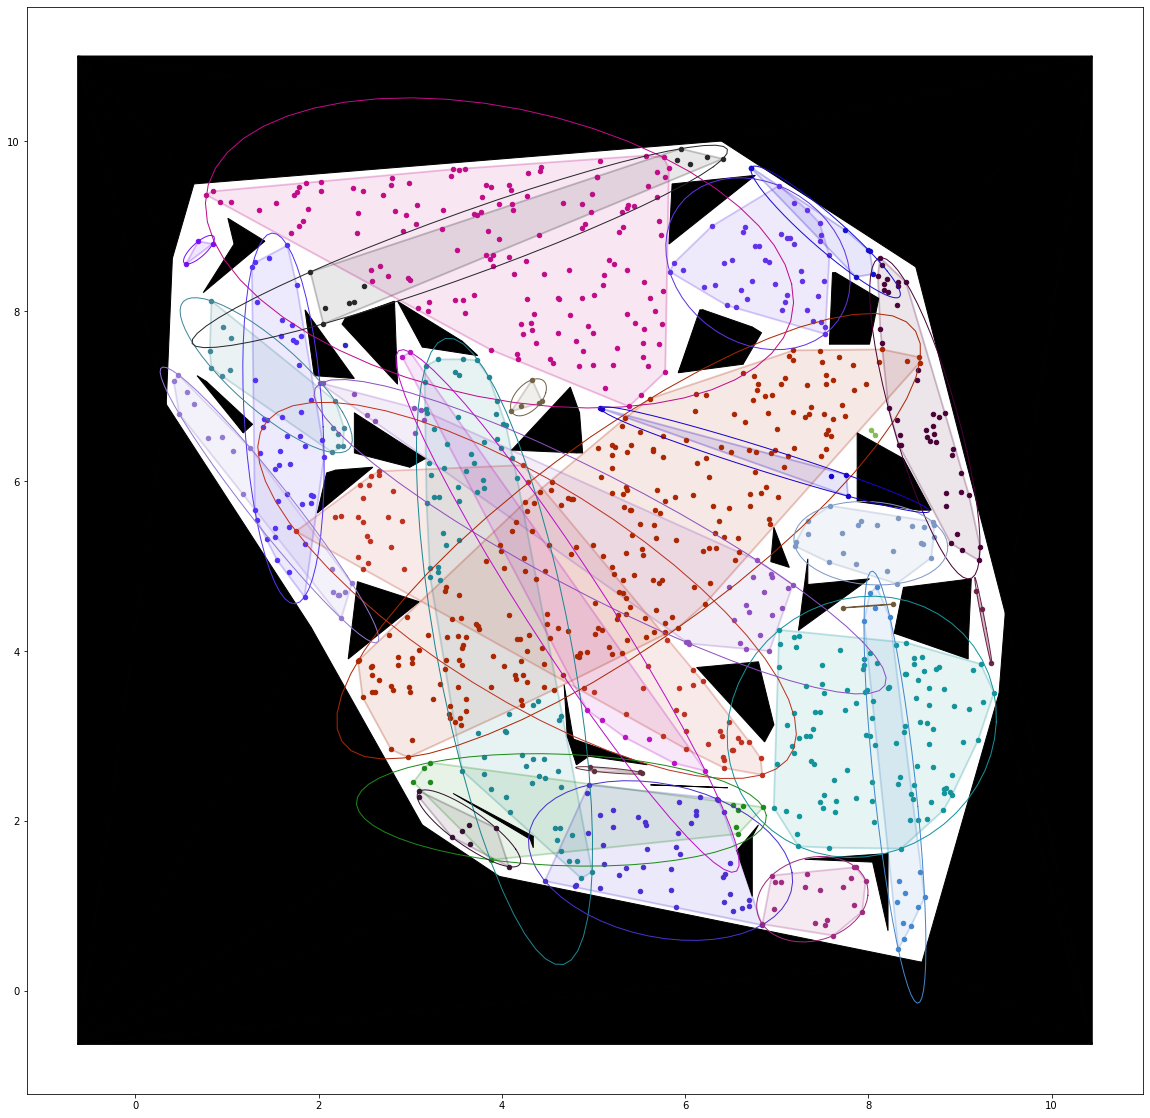

In [69]:
from utils import generate_random_colors
from seeding_utils import sorted_vertices
fig,ax = plt.subplots(figsize = (20,20))
ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)

colors = generate_random_colors(len(cliques_max))
for idx, c in enumerate(cliques_max):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    seed_ell = seed_ellipses[idx]
    scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = colc, zorder = 0)

        ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)
    if seed_ell is not None:plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

In [104]:
len(cliques_max)

28

In [70]:
from pydrake.all import Hyperellipsoid
def collision(pt):
    return world.visible(pt,pt)

def get_kernel_iris_metrics(cliques):
    seed_ellipses = [get_lj_ellipse(k) for k in cliques]
    seed_points = []
    for k,se in zip(cliques, seed_ellipses):
        center = se.center()
        if not collision(center):
            distances = np.linalg.norm(np.array(k).reshape(-1,2) - center, axis = 1).rehsape(-1)
            mindist_idx = np.argmin(distances)
            seed_points.append(k[mindist_idx])
        else:
            seed_points.append(center)

    #rescale seed_ellipses
    mean_eig_scaling = 1000
    seed_ellipses_scaled = []
    for e in seed_ellipses:
        eigs, _ = np.linalg.eig(e.A())
        mean_eig_size = np.mean(eigs)
        seed_ellipses_scaled.append(Hyperellipsoid(e.A()*(mean_eig_scaling/mean_eig_size), e.center()))
    #sort by size
    idxs = np.argsort([s.Volume() for s in seed_ellipses])[::-1]
    hs = [seed_points[i] for i in idxs]
    se = [seed_ellipses_scaled[i] for i in idxs]
    return hs, se

In [71]:
clique_mats = [pts[c,:] for c in cliques_max]

seed_points, metrics = get_kernel_iris_metrics(clique_mats)

In [78]:
import shapely
from shapely.ops import cascaded_union
from region_generation import generate_regions_ellipses_multi_threading
eps = 0.05
def compute_coverage(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def compute_coverage_cfree_tot(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def iris_w_obstacles(points, ellipsoids, region_obstacles, old_regions = None, use_region_obstacles = False):
    if N>=1:
        #+ region_obstacles
        obstacles = [r for r in world.obstacle_triangles]
        if use_region_obstacles:
            obstacles += region_obstacles
        regions, _, is_full = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain, compute_coverage, coverage_threshold=1-eps, old_regs = old_regions, maxiters=3)
    # else:
    #     #if N=1 coverage estimate happens at every step
    #     obstacles = [r for r in world.obstacle_triangles]
    #     if use_region_obstacles:
    #         obstacles += region_obstacles
    #     regions, _, _ = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain)
    #     is_full = 1-eps <= compute_coverage(old_regions+regions)
    return regions, is_full

In [79]:
regions, is_full = iris_w_obstacles(seed_points, metrics, [], [])

[17:33:25]  1 / 1
[17:33:27]  1 / 1


<ipython-input-78-25a550c33fc2>:10: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


[17:33:28]  1 / 1
[17:33:30]  1 / 1
[17:33:31]  1 / 1
[17:33:33]  1 / 1
[17:33:34]  1 / 1
[17:33:35]  1 / 1
[17:33:37]  1 / 1
[17:33:39]  1 / 1
[17:33:40]  1 / 1
[17:33:42]  1 / 1
[17:33:43]  1 / 1
[17:33:45]  1 / 1
[17:33:47]  1 / 1
[17:33:48]  1 / 1
[17:33:49]  1 / 1
[17:33:51]  1 / 1
[17:33:52]  1 / 1
[17:33:54]  1 / 1
[17:33:56]  1 / 1
[17:33:57]  1 / 1
[17:33:59]  1 / 1
[17:34:01]  1 / 1
[17:34:02]  1 / 1
[17:34:04]  1 / 1
[17:34:06]  1 / 1
[17:34:07]  1 / 1


<ipython-input-78-25a550c33fc2>:10: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


0.9501131059966137


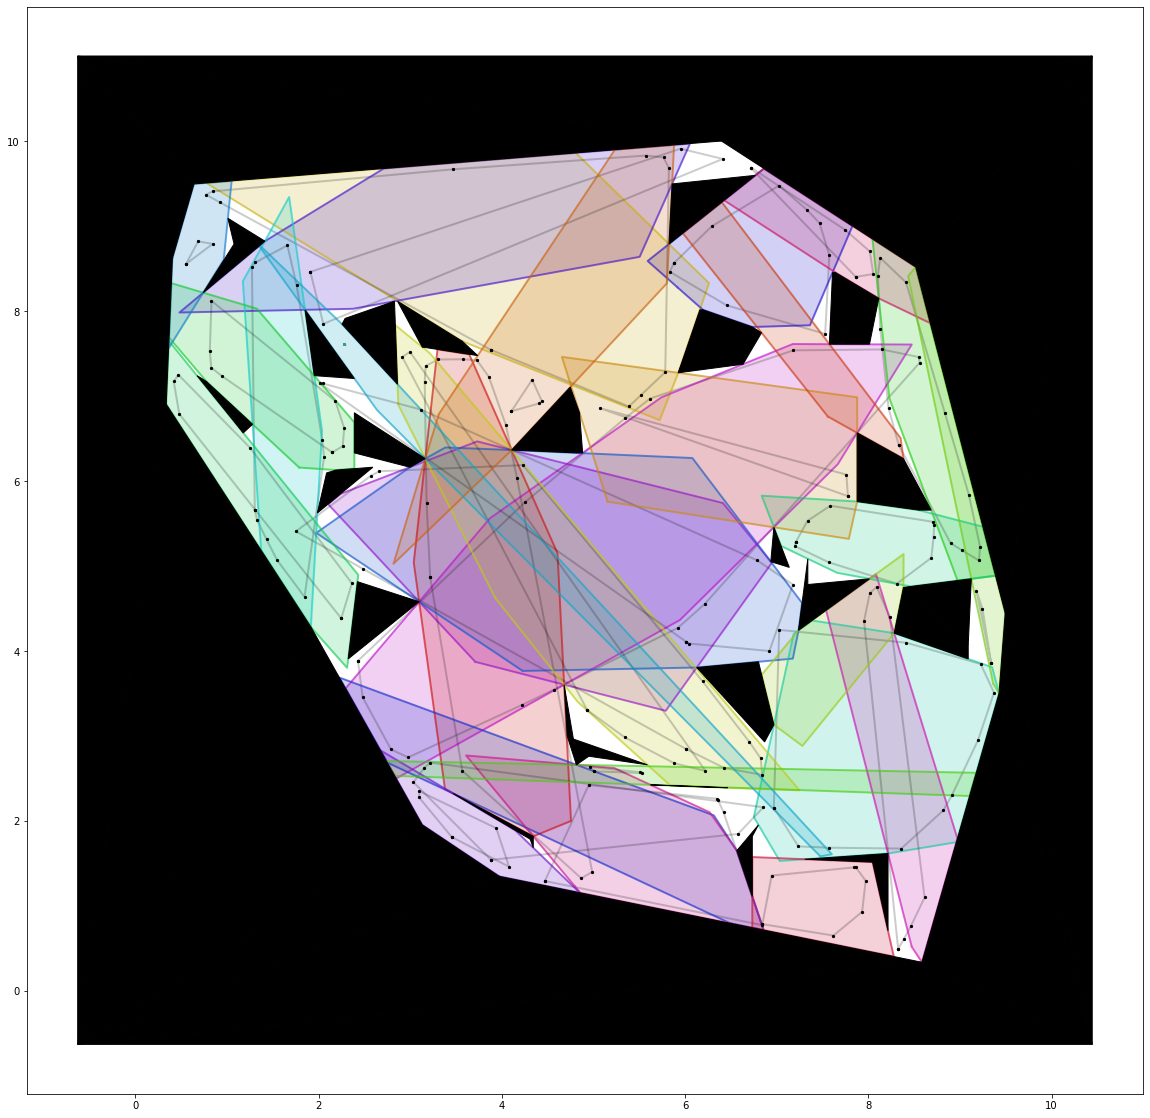

In [81]:
from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices
fig,ax = plt.subplots(figsize = (20,20))
#ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)
print(compute_coverage(regions))
colors = generate_maximally_different_colors(len(cliques_max))
for idx, c in enumerate(cliques_max):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    reg = regions[idx]
    #seed_ell = seed_ellipses[idx]
    #scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = 'k', zorder = 0)
        ax.scatter(v[:,0], v[:,1], c = 'k', s = 5)
        #ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)

    v = sorted_vertices(VPolytope(reg)).T#s
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.6, c = colc, zorder = 0)
    ax.fill(v[:,0], v[:,1], alpha = 0.2, c = p[0].get_color(), zorder = 0)
    if seed_ell is not None:plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

<ipython-input-75-741c5e79ad29>:10: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


0.9492527508281613


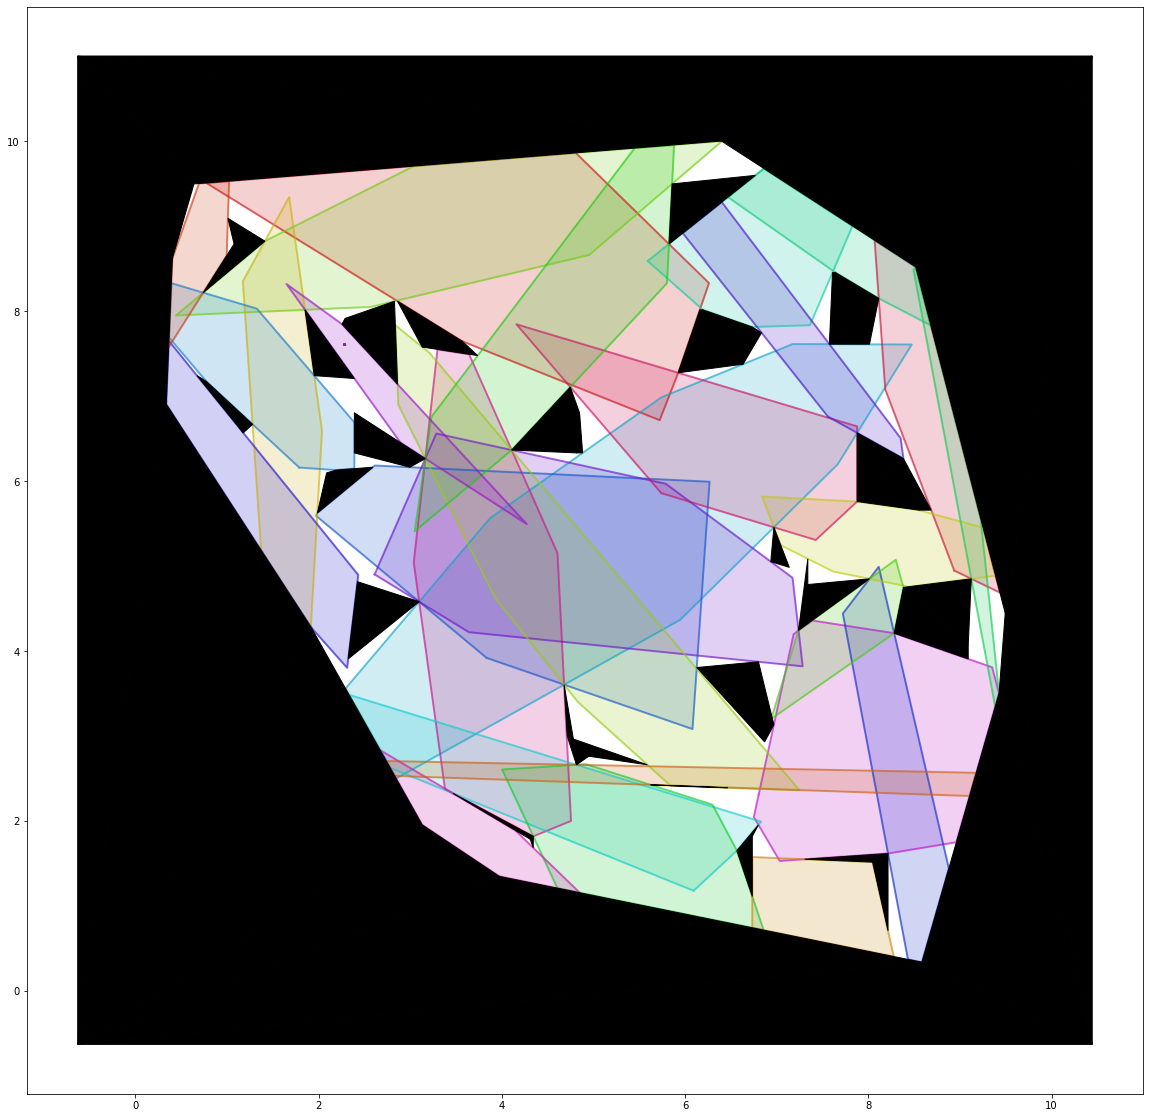

In [77]:
from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices
fig,ax = plt.subplots(figsize = (20,20))
#ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)
print(compute_coverage(regions))
colors = generate_maximally_different_colors(len(cliques_max))
for idx, c in enumerate(cliques_max):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    reg = regions[idx]
    #seed_ell = seed_ellipses[idx]
    #scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        #p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = 'k', zorder = 0)

        #ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)

    v = sorted_vertices(VPolytope(reg)).T#s
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.6, c = colc, zorder = 0)
    ax.fill(v[:,0], v[:,1], alpha = 0.2, c = p[0].get_color(), zorder = 0)
    if seed_ell is not None:plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

In [82]:
len(regions)

28